In [219]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Concatenate, Flatten, Dot, Lambda
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, average_precision_score, precision_score, ndcg_score



import warnings
from pandas.errors import DtypeWarning
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore', category=DtypeWarning)

	•	reviews_0-250.csv: Contains reviews for products indexed from 0 to 250.  
	•	reviews_250-500.csv: Contains reviews for products indexed from 250 to 500.  
	•	reviews_500-750.csv: Contains reviews for products indexed from 500 to 750.  
	•	reviews_750-1250.csv: Contains reviews for products indexed from 750 to 1250.  
	•	reviews_1250-end.csv: Contains reviews for products indexed from 1250 to the last product in the dataset.  

This segmentation is likely implemented to manage file sizes and facilitate easier data handling. Each file encompasses all reviews associated with the products within the specified index range.

In [95]:
pro_inf = pd.read_csv('sephora_datasets/product_info.csv')
pro_inf_original = pro_inf.copy()
rew_1 = pd.read_csv('sephora_datasets/reviews_0-250.csv')
rew_2 = pd.read_csv('sephora_datasets/reviews_250-500.csv')
rew_3 = pd.read_csv('sephora_datasets/reviews_500-750.csv')
rew_4 = pd.read_csv('sephora_datasets/reviews_750-1250.csv')
rew_5 = pd.read_csv('sephora_datasets/reviews_1250-end.csv')

files = [
    "reviews_0-250.csv",
    "reviews_250-500.csv",
    "reviews_500-750.csv",
    "reviews_750-1250.csv",
    "reviews_1250-end.csv"
]

df_reviews = pd.concat([rew_1, rew_2, rew_3, rew_4, rew_5], ignore_index=True, axis=0)
print("Combined shape:", df_reviews.shape)

Combined shape: (1094411, 19)


In [96]:
df_reviews_final = df_reviews[['product_id', 'author_id', 'rating']].copy()

In [97]:
df_reviews_final[['product_id', 'author_id']].nunique()

product_id      2351
author_id     578653
dtype: int64

In [99]:
display(pro_inf.nunique())
print('************************** missing values:')
display(pro_inf.isnull().sum())

product_id            8494
product_name          8415
brand_id               304
brand_name             304
loves_count           7436
rating                4394
reviews               1556
size                  2055
variation_type           7
variation_value       2729
variation_desc         935
ingredients           6538
price_usd              298
value_price_usd        174
sale_price_usd          88
limited_edition          2
new                      2
online_only              2
out_of_stock             2
sephora_exclusive        2
highlights            4417
primary_category         9
secondary_category      41
tertiary_category      118
child_count             55
child_max_price        222
child_min_price        208
dtype: int64

************************** missing values:


product_id               0
product_name             0
brand_id                 0
brand_name               0
loves_count              0
rating                 278
reviews                278
size                  1631
variation_type        1444
variation_value       1598
variation_desc        7244
ingredients            945
price_usd                0
value_price_usd       8043
sale_price_usd        8224
limited_edition          0
new                      0
online_only              0
out_of_stock             0
sephora_exclusive        0
highlights            2207
primary_category         0
secondary_category       8
tertiary_category      990
child_count              0
child_max_price       5740
child_min_price       5740
dtype: int64

#### use later: variation_value, variation_desc, size.
#### use later (important): ingredients, highlights

## Item Matrix

In [134]:
df = pro_inf.copy()

In [135]:
core_columns_item = [
    'product_id', 'brand_id', 'price_usd', 'limited_edition', 'new',
    'online_only', 'out_of_stock', 'sephora_exclusive', 'primary_category',
    'child_count', 'variation_type'
]
columns_to_impute = ['rating', 'reviews', 'child_max_price', 'child_min_price']
columns_to_drop_item = [
    'product_name', 'brand_name', 'value_price_usd', 'sale_price_usd',
    'size', 'variation_value', 'variation_desc', 'tertiary_category'
]

In [136]:
df_cleaned = df.drop(columns=columns_to_drop_item)

In [137]:
brand_freq = df_cleaned['brand_id'].value_counts()
df_cleaned['brand_freq'] = df_cleaned['brand_id'].map(brand_freq)

# Log-scaling
# Helps reduce dominance of very high-frequency brands
df_cleaned['brand_freq_log'] = np.log1p(df_cleaned['brand_freq'])  # log(1 + x) to avoid log(0)

# Normalize (MinMax scaling to [0, 1])
scaler = MinMaxScaler()
df_cleaned['brand_freq_scaled'] = scaler.fit_transform(df_cleaned[['brand_freq_log']])

brand_freq_scaled_mapping = (
    df_cleaned[['brand_id', 'brand_freq_scaled']]
    .drop_duplicates(subset='brand_id')
    .set_index('brand_id')
    .squeeze()  # turns DataFrame → Series
    .to_dict()
)

In [138]:
for col in columns_to_impute:
    if col in df_cleaned.columns:
        if col in ['rating', 'child_max_price', 'child_min_price']:
            df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce').fillna(df_cleaned[col].median())
        elif col == 'reviews':
            df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce').fillna(0)

# Fill missing categorical with "Unknown"
df_cleaned['primary_category'] = df_cleaned['primary_category'].fillna("Unknown")
df_cleaned['variation_type'] = df_cleaned['variation_type'].fillna("Unknown")

# One-hot encode variation_type and primary_category (few unique values)
df_encoded = pd.get_dummies(df_cleaned, columns=['variation_type', 'primary_category'], prefix=['var_type', 'pc'])

# Final item feature matrix
df_encoded = df_encoded.astype({col: 'int' for col in df_encoded.columns if df_encoded[col].dtype == 'bool'})
df_encoded = df_encoded.drop(columns=['ingredients', 'highlights', 'secondary_category'])
df_encoded = df_encoded.drop(['brand_id', 'brand_freq', 'brand_freq_log'], axis=1)

In [139]:
item_features_ordered = df_reviews_final[['product_id']].merge(df_encoded, on="product_id", how="left")

## User Matrix

In [140]:
print('************************ nunique_values:')
display(rew_1.nunique())
print('************************ missing values:')
display(rew_1.isnull().sum())
print('************************ shape:')
print(rew_1.shape)

************************ nunique_values:


Unnamed: 0                  602130
author_id                   383697
rating                           5
is_recommended                   2
helpfulness                   2314
total_feedback_count           551
total_neg_feedback_count       207
total_pos_feedback_count       484
submission_time               5317
review_text                 508467
review_title                202373
skin_tone                       14
eye_color                        6
skin_type                        4
hair_color                       7
product_id                     250
product_name                   249
brand_name                      60
price_usd                       92
dtype: int64

************************ missing values:


Unnamed: 0                       0
author_id                        0
rating                           0
is_recommended              117486
helpfulness                 331832
total_feedback_count             0
total_neg_feedback_count         0
total_pos_feedback_count         0
submission_time                  0
review_text                    999
review_title                167011
skin_tone                   106056
eye_color                   138488
skin_type                    74683
hair_color                  141081
product_id                       0
product_name                     0
brand_name                       0
price_usd                        0
dtype: int64

************************ shape:
(602130, 19)


In [141]:
mask_no_feedback = (df_reviews['total_feedback_count'] == 0)
df_reviews.loc[mask_no_feedback, 'helpfulness'] = 0.0

for col in ['skin_tone', 'eye_color', 'skin_type', 'hair_color']:
    df_reviews[col] = df_reviews[col].fillna("Unknown")

user_agg = df_reviews.groupby("author_id").agg({
    "rating": ["mean", "count"],
    "is_recommended": "mean",
    "helpfulness": "mean",
    "skin_tone": "first",
    "skin_type": "first",
    "eye_color": "first",
    "hair_color": "first"
})
user_agg.columns = ['rating_avg', 'rating_count', 'recommend_ratio', 'helpfulness_avg',
                    'skin_tone', 'skin_type', 'eye_color', 'hair_color']
user_agg = user_agg.reset_index()

user_features = pd.get_dummies(user_agg, 
    columns=['skin_tone', 'skin_type', 'eye_color', 'hair_color'],
    prefix=['tone', 'type', 'eye', 'hair'])

global_recommend_avg = df_reviews["is_recommended"].mean()
user_features["recommend_missing"] = user_features["recommend_ratio"].isna().astype(int)
user_features["recommend_ratio"] = user_features["recommend_ratio"].fillna(global_recommend_avg)

user_features = user_features.astype({col: 'int' for col in user_features.columns if user_features[col].dtype == 'bool'})

In [142]:
user_features_ordered = df_reviews_final[['author_id']].merge(user_features, on="author_id", how="left")

In [143]:
user_features_ordered.head()

,author_id,rating_avg,rating_count,recommend_ratio,helpfulness_avg,tone_Unknown,tone_dark,tone_deep,tone_ebony,tone_fair,tone_fairLight,tone_light,tone_lightMedium,tone_medium,tone_mediumTan,tone_notSureST,tone_olive,tone_porcelain,tone_rich,tone_tan,type_Unknown,type_combination,type_dry,type_normal,type_oily,eye_Grey,eye_Unknown,eye_blue,eye_brown,eye_gray,eye_green,eye_hazel,hair_Unknown,hair_auburn,hair_black,hair_blonde,hair_brown,hair_brunette,hair_gray,hair_red,recommend_missing
0,1741593524,5.0,1,1.0,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
1,31423088263,1.0,1,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,5061282401,5.0,1,1.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
3,6083038851,5.0,1,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
4,47056667835,5.0,1,1.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0


In [144]:
item_features_ordered.head()

,product_id,loves_count,rating,reviews,price_usd,limited_edition,new,online_only,out_of_stock,sephora_exclusive,child_count,child_max_price,child_min_price,brand_freq_scaled,var_type_Color,var_type_Formulation,var_type_Scent,var_type_Size,var_type_Size + Concentration,var_type_Size + Concentration + Formulation,var_type_Type,var_type_Unknown,pc_Bath & Body,pc_Fragrance,pc_Gifts,pc_Hair,pc_Makeup,pc_Men,pc_Mini Size,pc_Skincare,pc_Tools & Brushes
0,P504322,177,5.0000,1.0,19.0,0,0,1,0,0,0,32.0,28.0,0.606089,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,P420652,1081315,4.3508,16118.0,24.0,0,0,0,0,1,3,24.0,24.0,0.510128,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,P420652,1081315,4.3508,16118.0,24.0,0,0,0,0,1,3,24.0,24.0,0.510128,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,P420652,1081315,4.3508,16118.0,24.0,0,0,0,0,1,3,24.0,24.0,0.510128,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,P420652,1081315,4.3508,16118.0,24.0,0,0,0,0,1,3,24.0,24.0,0.510128,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


## Final Touches on User & Item Datasets

In [154]:
num_user_features = user_features_ordered.shape[1] - 1
num_item_features = item_features_ordered.shape[1] - 1

u_s = 1  # start of columns to use in training, user
i_s = 1  # start of columns to use in training, items

print(num_user_features)
print(num_item_features)

40
30


In [205]:
user_train_save, user_test_save = train_test_split(user_features_ordered, train_size=0.80, shuffle=True, random_state=1)
user_test_ids = user_test_save.author_id.values

In [206]:
user_features_ordered_np = user_features_ordered.to_numpy()
item_features_ordered_np = item_features_ordered.to_numpy()

print(df_reviews_final.shape)
print(user_features_ordered.shape)
print(item_features_ordered.shape)

(1094411, 3)
(1094411, 41)
(1094411, 31)


In [207]:
item_train, item_test = train_test_split(item_features_ordered_np, train_size=0.80, shuffle=True, random_state=1)
user_train, user_test = train_test_split(user_features_ordered_np, train_size=0.80, shuffle=True, random_state=1)
y_train, y_test       = train_test_split(df_reviews_final.rating.to_numpy(), train_size=0.80, shuffle=True, random_state=1)

In [208]:
scalerItem = StandardScaler()
scalerItem.fit(item_train[:, i_s:])
item_train[:, i_s:] = scalerItem.transform(item_train[:, i_s:])

scalerUser = StandardScaler()
scalerUser.fit(user_train[:, u_s:])
user_train[:, u_s:] = scalerUser.transform(user_train[:, u_s:])

scalerTarget = MinMaxScaler((-1, 1))
scalerTarget.fit(y_train.reshape(-1, 1))
y_train = scalerTarget.transform(y_train.reshape(-1, 1))

## Starting Building the Model

In [173]:
num_outputs = 32
tf.random.set_seed(1)

user_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs)
])

item_NN = tf.keras.models.Sequential([  
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(num_outputs)
])

# create the user input and point to the base network
input_user = tf.keras.layers.Input(shape=(num_user_features,))
vu = user_NN(input_user)
vu = Lambda(lambda x: tf.linalg.l2_normalize(x, axis=1), name="vu_normalized")(vu)


# create the item input and point to the base network
input_item = tf.keras.layers.Input(shape=(num_item_features,))
vm = item_NN(input_item)
vm = Lambda(lambda x: tf.linalg.l2_normalize(x, axis=1), name="vm_normalized")(vm)

# compute the dot product of the two vectors vu and vm
output = tf.keras.layers.Dot(axes=1)([vu, vm])

# specify the inputs and output of the model
model = tf.keras.Model([input_user, input_item], output)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 32)        │     47,520 │ input_layer_4[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 32)        │     44,960 │ input_layer_6[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vu_normalized       │ (None, 32)        │          0 │ sequential_6[0][… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vm_normalized       │ (None, 32)        │          0 │ sequential_7[0][… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ vu_normalized[0]… │
│                     │                   │            │ vm_normalized[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 92,480 (361.25 KB)

 Trainable params: 92,480 (361.25 KB)

 Non-trainable params: 0 (0.00 B)

In [175]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt,
              loss=cost_fn)

tf.random.set_seed(1)

model.fit([tf.convert_to_tensor(user_train[:, u_s:], dtype=tf.float32), tf.convert_to_tensor(item_train[:, i_s:],dtype=tf.float32)], tf.convert_to_tensor(y_train, dtype=tf.float32), epochs=30)

Epoch 1/30
27361/27361 ━━━━━━━━━━━━━━━━━━━━ 18s 646us/step - loss: 0.0915
Epoch 2/30
27361/27361 ━━━━━━━━━━━━━━━━━━━━ 18s 663us/step - loss: 0.0842
Epoch 3/30
27361/27361 ━━━━━━━━━━━━━━━━━━━━ 18s 671us/step - loss: 0.0831
Epoch 4/30
27361/27361 ━━━━━━━━━━━━━━━━━━━━ 18s 651us/step - loss: 0.0826
Epoch 5/30
27361/27361 ━━━━━━━━━━━━━━━━━━━━ 18s 643us/step - loss: 0.0823
Epoch 6/30
27361/27361 ━━━━━━━━━━━━━━━━━━━━ 18s 652us/step - loss: 0.0819
Epoch 7/30
27361/27361 ━━━━━━━━━━━━━━━━━━━━ 18s 641us/step - loss: 0.0815
Epoch 8/30
27361/27361 ━━━━━━━━━━━━━━━━━━━━ 18s 645us/step - loss: 0.0812
Epoch 9/30
27361/27361 ━━━━━━━━━━━━━━━━━━━━ 17s 626us/step - loss: 0.0810
Epoch 10/30
27361/27361 ━━━━━━━━━━━━━━━━━━━━ 18s 669us/step - loss: 0.0808
Epoch 11/30
27361/27361 ━━━━━━━━━━━━━━━━━━━━ 18s 652us/step - loss: 0.0807
Epoch 12/30
27361/27361 ━━━━━━━━━━━━━━━━━━━━ 19s 683us/step - loss: 0.0805
Epoch 13/30
27361/27361 ━━━━━━━━━━━━━━━━━━━━ 19s 691us/step - loss: 0.0804
Epoch 14/30
27361/27361 ━━━━━━━━━━

### MAE, RMSE, MSE

In [182]:
# Apply the SAME scalers used on training data

item_test_scaled = item_test
user_test_scaled = user_test
y_test_scaled = y_test

item_test_scaled[:, i_s:] = scalerItem.transform(item_test[:, i_s:])
user_test_scaled[:, u_s:] = scalerUser.transform(user_test[:, u_s:])
y_test_scaled = scalerTarget.transform(y_test.reshape(-1, 1))

model.evaluate(
    [tf.convert_to_tensor(user_test_scaled[:, u_s:], dtype=tf.float32),
     tf.convert_to_tensor(item_test_scaled[:, i_s:], dtype=tf.float32)],
    tf.convert_to_tensor(y_test_scaled, dtype=tf.float32)
)

6841/6841 ━━━━━━━━━━━━━━━━━━━━ 2s 256us/step - loss: 0.0800


0.08037059009075165

In [186]:
# Predict on scaled test data
y_pred_scaled = model.predict([
    tf.convert_to_tensor(user_test_scaled[:, u_s:], dtype=tf.float32),
    tf.convert_to_tensor(item_test_scaled[:, i_s:], dtype=tf.float32)
])

# Inverse transform predictions and true ratings back to original scale
y_pred_orig = scalerTarget.inverse_transform(y_pred_scaled)
y_test_orig = scalerTarget.inverse_transform(y_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
mse = mean_squared_error(y_test_orig, y_pred_orig)
mae = mean_absolute_error(y_test_orig, y_pred_orig)

print("Test RMSE:", rmse)
print("Test MSE:", mse)
print("Test MAE:", mae)

6841/6841 ━━━━━━━━━━━━━━━━━━━━ 2s 287us/step
Test RMSE: 0.5669941286323601
Test MSE: 0.3214823419035693
Test MAE: 0.299625604957952


MSE --> Scaled [-1 to 1 scale] --> 0.08037 --> Model loss during training/eval  
RMSE --> Original (1 to 5 scale) --> 0.567 --> Avg error in predicted rating  

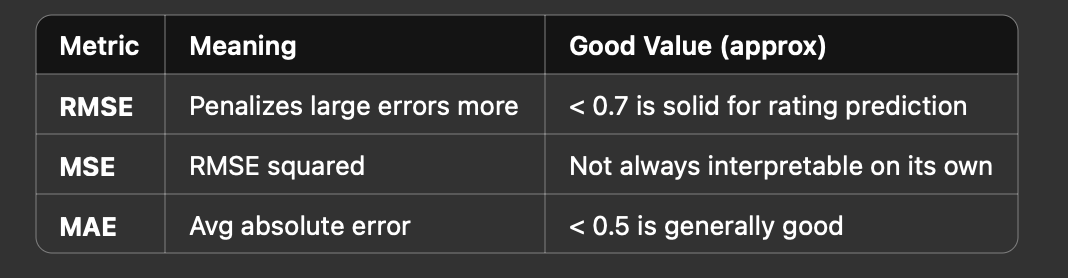

## avg_precision, avg_recall, avg_f1, avg_accuracy

In [216]:
"""
def precision_recall_f1_nn(user_ids_test, y_test_orig, y_pred_orig, threshold=3.5):
    '''
    Computes average precision, recall, F1, and accuracy across users.
    
    Parameters:
      - user_ids_test: array-like, user IDs corresponding to each test row.
      - y_test_orig: array-like, true ratings in the original scale.
      - y_pred_orig: array-like, predicted ratings in the original scale.
      - threshold: float, threshold to decide if a rating is considered 'positive'
    
    Returns:
      avg_precision, avg_recall, avg_f1, avg_accuracy
    '''
    
    # Map predictions and true ratings to user IDs
    user_est_true = defaultdict(list)
    for uid, true_r, est in zip(user_ids_test, y_test_orig, y_pred_orig):
        user_est_true[uid].append((est, true_r))
    
    precisions = {}
    recalls = {}
    f1s = {}
    accuracies = {}
    
    for uid, ratings in user_est_true.items():
        # Create binary labels: 1 if rating >= threshold, else 0
        y_true = [1 if (true_r >= threshold) else 0 for (_, true_r) in ratings]
        y_pred_labels = [1 if (est >= threshold) else 0 for (est, _) in ratings]
        
        precisions[uid] = precision_score(y_true, y_pred_labels, zero_division=0)
        recalls[uid] = recall_score(y_true, y_pred_labels, zero_division=0)
        f1s[uid] = f1_score(y_true, y_pred_labels, zero_division=0)
        accuracies[uid] = accuracy_score(y_true, y_pred_labels)
    
    # Average the scores over all users
    avg_precision = sum(precisions.values()) / len(precisions) if precisions else 0.
    avg_recall = sum(recalls.values()) / len(recalls) if recalls else 0.
    avg_f1 = sum(f1s.values()) / len(f1s) if f1s else 0.
    avg_accuracy = sum(accuracies.values()) / len(accuracies) if accuracies else 0.
    
    return avg_precision, avg_recall, avg_f1, avg_accuracy
"""
print()

In [218]:
"""
avg_precision, avg_recall, avg_f1, avg_accuracy = precision_recall_f1_nn(
    user_ids_test=user_test_ids, 
    y_test_orig=y_test_orig.reshape(-1),  # flatten if necessary
    y_pred_orig=y_pred_orig.reshape(-1),
    threshold=3.5
)

print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1 Score:", avg_f1)
print("Average Accuracy:", avg_accuracy)
"""
print()

In [214]:
def precision_recall_f1_nn_vectorized(user_ids_test, y_test_orig, y_pred_orig, threshold=3.5):
    """
    Computes average precision, recall, F1, and accuracy across users in a vectorized manner.
    
    Parameters:
      - user_ids_test: array-like, user IDs for each test record.
      - y_test_orig: array-like, true ratings in the original scale.
      - y_pred_orig: array-like, predicted ratings in the original scale.
      - threshold: float, threshold above which a rating is considered "positive".
      
    Returns:
      avg_precision, avg_recall, avg_f1, avg_accuracy
    """
    
    y_true_bin = (np.array(y_test_orig).flatten() >= threshold).astype(int)
    y_pred_bin = (np.array(y_pred_orig).flatten() >= threshold).astype(int)
    
    df = pd.DataFrame({
        'user': user_ids_test,
        'true': y_true_bin,
        'pred': y_pred_bin
    })
    
    # Group by user and compute aggregated statistics:
    # - n_tp: number of true positives
    # - n_pred: total predicted positives
    # - n_true: total actual positives
    # - n_total: total number of ratings for the user
    # - n_correct: total correct predictions
    grouped = df.groupby('user').agg(
        n_tp = ('true', lambda x: np.sum(x * df.loc[x.index, 'pred'])),
        n_pred = ('pred', 'sum'),
        n_true = ('true', 'sum'),
        n_total = ('true', 'size'),
        n_correct = ('true', lambda x: np.sum(x == df.loc[x.index, 'pred']))
    )
    
    grouped['precision'] = grouped['n_tp'] / grouped['n_pred'].replace(0, np.nan)
    grouped['recall'] = grouped['n_tp'] / grouped['n_true'].replace(0, np.nan)
    grouped['accuracy'] = grouped['n_correct'] / grouped['n_total']
    grouped['f1'] = 2 * (grouped['precision'] * grouped['recall']) / (grouped['precision'] + grouped['recall'])
    
    grouped = grouped.fillna(0)
    
    avg_precision = grouped['precision'].mean()
    avg_recall = grouped['recall'].mean()
    avg_f1 = grouped['f1'].mean()
    avg_accuracy = grouped['accuracy'].mean()
    
    return avg_precision, avg_recall, avg_f1, avg_accuracy

In [215]:
avg_precision, avg_recall, avg_f1, avg_accuracy = precision_recall_f1_nn_vectorized(
    user_ids_test=user_test_ids, 
    y_test_orig=y_test_orig, 
    y_pred_orig=y_pred_orig, 
    threshold=3.5
)

print("Average Precision:", avg_precision)
print("Average Recall:", avg_recall)
print("Average F1 Score:", avg_f1)
print("Average Accuracy:", avg_accuracy)

Average Precision: 0.7924134321363068
Average Recall: 0.8004354831636965
Average F1 Score: 0.7948499456751398
Average Accuracy: 0.9438953316466984


## avg_precision, avg_recall, avg_f1, avg_accuracy

In [ ]:
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.metrics import average_precision_score, precision_score, ndcg_score

def measures_at_k_nn(user_ids_test, y_test_orig, y_pred_orig, k=10, threshold=3.5):
    """
    Computes average average_precision, precision@k, and nDCG@k across users
    for predictions from a two-tower model.
    
    Parameters:
      - user_ids_test: array-like of user IDs (one per test record)
      - y_test_orig: array-like of true ratings (original scale)
      - y_pred_orig: array-like of predicted ratings (original scale)
      - k: int, the number of top items to consider for "at k" metrics
      - threshold: float, the rating value at or above which an item is considered relevant
      
    Returns:
      avg_average_precision, avg_precision_at_k, avg_ndcg_at_k
    """
    # Ensure inputs are NumPy arrays and flatten if necessary.
    user_ids_test = np.array(user_ids_test).flatten()
    y_test_orig = np.array(y_test_orig).flatten()
    y_pred_orig = np.array(y_pred_orig).flatten()
    
    # Create a DataFrame with a row per test record.
    df = pd.DataFrame({
        'user': user_ids_test,
        'true': y_test_orig,
        'pred': y_pred_orig
    })
    
    # Convert true and predicted ratings into binary labels based on the threshold.
    df['true_bin'] = (df['true'] >= threshold).astype(int)
    df['pred_bin'] = (df['pred'] >= threshold).astype(int)
    
    # Group the DataFrame by user ID.
    user_est_true = df.groupby('user')
    
    average_precisions = {}
    precisions_at_k = {}
    ndcgs_at_k = {}
    
    for uid, group in user_est_true:
        # Convert each user's group to a list of tuples: (predicted rating, true rating, binary true)
        # Sort the user’s items by predicted rating in descending order.
        sorted_group = group.sort_values(by='pred', ascending=False)
        y_true = sorted_group['true_bin'].tolist()
        y_pred = sorted_group['pred_bin'].tolist()
        
        # Calculate binary labels at top-k.
        y_true_at_k = y_true[:k]
        y_pred_at_k = y_pred[:k]
        
        # Compute average precision over the full ranked list if the user has any relevant items.
        if sum(y_true) > 0:
            average_precisions[uid] = average_precision_score(sorted_group['true_bin'], sorted_group['pred_bin'])
        else:
            average_precisions[uid] = 0.0
        
        # Compute precision at k.
        precisions_at_k[uid] = precision_score(y_true_at_k, y_pred_at_k, zero_division=0)
        
        # For nDCG, we want to use the raw ratings (not binary) and consider the ranking.
        # nDCG expects input arrays of shape (1, n); here we convert the sorted true and predicted ratings.
        if len(sorted_group) > 1:
            true_rel = np.asarray(sorted_group['true'].tolist()).reshape(1, -1)
            pred_rel = np.asarray(sorted_group['pred'].tolist()).reshape(1, -1)
            ndcgs_at_k[uid] = ndcg_score(true_rel, pred_rel, k=k)
        else:
            # If there's only one item, then we'll return a simple binary match.
            ndcgs_at_k[uid] = 1.0 if (y_true[0] == y_pred[0] and y_true[0] == 1) else 0.0
    
    # Average metrics across all users.
    avg_average_precision = np.mean(list(average_precisions.values()))
    avg_precision_at_k = np.mean(list(precisions_at_k.values()))
    avg_ndcg_at_k = np.mean(list(ndcgs_at_k.values()))
    
    return avg_average_precision, avg_precision_at_k, avg_ndcg_at_k

# --- Example usage ---
# Suppose you have the following outputs from your two-tower model evaluation on the test set:
# user_ids_test: an array of user IDs (one per record)
# y_test_orig: an array of true ratings (original scale, e.g., 1-5)
# y_pred_orig: an array of predicted ratings (original scale)
#
# You would call the function as follows:

# avg_ap, avg_prec_k, avg_ndcg_k = measures_at_k_nn(user_ids_test, y_test_orig, y_pred_orig, k=10, threshold=3.5)
# print("Avg. Average Precision:", avg_ap)
# print("Avg. Precision@10:", avg_prec_k)
# print("Avg. nDCG@10:", avg_ndcg_k)